In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [2]:
df = pd.read_csv("processed_data/final_pre-processed.csv")

In [3]:
df = df.drop('Unnamed: 0',axis=1)
df["Ratings"] = df["Ratings"].astype(int)

In [4]:
df["Ratings"].value_counts()

Ratings
1    4534
0     634
Name: count, dtype: int64

In [6]:
df["Ratings"].value_counts()

Ratings
1    4534
0     634
Name: count, dtype: int64

In [7]:
text_vectorizer = TfidfVectorizer(max_df=.8)
text_vectorizer.fit(df['reviewText'])
def rate(r):
    ary2 = []
    for rating in r:
        tv = [0,0]
        tv[rating-1] = 1
        ary2.append(tv)
    return np.array(ary2)

In [8]:
X = text_vectorizer.transform(df['reviewText']).toarray()
y = df['Ratings']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [9]:
NUM_ROUNDS = 10
NUM_CLIENTS = 10
BATCH_SIZE = 256
EPOCHS_PER_ROUND = 10
LEARNING_RATE = 0.1
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-7

In [10]:
global_model = Sequential()
global_model.add(Dense(128,input_dim=X_train.shape[1]))
global_model.add(Dense(1,activation='softmax'))

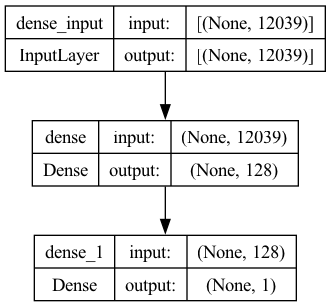

In [11]:
import visualkeras

model = global_model

from tensorflow.keras.utils import plot_model

# Assuming `model` is your Keras modelz
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [12]:
global_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
# SERVER ADAM OPTIMIZER 
fedadam = tf.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=BETA_1,beta_2 = BETA_2,epsilon=EPSILON)

In [14]:
# # Train the Normal model
# model = global_model
# model.compile(optimizer=fedadam, loss='categorical_crossentropy',metrics=['accuracy'])
# model.fit(X_train,y_train,epochs=5,batch_size=20)

# acc = model.evaluate(X_test,y_test)
# print(acc)

In [15]:
x_train_clients = np.array_split(X_train,NUM_CLIENTS)
y_train_clients = np.array_split(y_train,NUM_CLIENTS)

x_test_clients = np.array_split(X_test,NUM_CLIENTS)
y_test_clients = np.array_split(y_test,NUM_CLIENTS)

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [16]:
from sklearn.metrics import classification_report
import keras 

client_models = []
client_losses = []
client_train_losses = []
client_classification = []
client_acc = []
global_maes = []

client_models = []
for i in range(NUM_CLIENTS):
    local_model = Sequential()
    local_model.add(Dense(128,input_dim=X_train.shape[1]))
    local_model.add(Dense(1,activation='softmax'))
    local_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    # Initialize an empty list to store the training loss
    training_losses = []

    # Define a custom callback to capture training loss
    class LossHistory(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            training_losses.append(logs['loss'])

    #  Fit the model with the training data and capture the training loss
    history_callback = local_model.fit(x_train_clients[i],y_train_clients[i], epochs=EPOCHS_PER_ROUND, callbacks=[LossHistory()])

    local_model.fit(x_train_clients[i],y_train_clients[i],epochs=EPOCHS_PER_ROUND, batch_size=BATCH_SIZE,verbose=0)
    acc = local_model.evaluate(x_test_clients[i],y_test_clients[i])
    preds = local_model.predict(x_test_clients[i])
    c2 = classification_report(y_test_clients[i],preds)
    client_models.append(local_model)
    client_train_losses.append(training_losses)
    client_acc.append(acc[1])
    client_classification.append(c2)
    client_models.append(local_model)

Epoch 1/10
13/13 [==============================] - 1s 33ms/step - loss: 0.5928 - accuracy: 0.8720
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 0.4233 - accuracy: 0.8720
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 0.3444 - accuracy: 0.8720
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 0.2945 - accuracy: 0.8720
Epoch 5/10
13/13 [==============================] - 0s 19ms/step - loss: 0.2472 - accuracy: 0.8720
Epoch 6/10
13/13 [==============================] - 0s 18ms/step - loss: 0.2045 - accuracy: 0.8720
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 0.1671 - accuracy: 0.8720
Epoch 8/10
13/13 [==============================] - 0s 15ms/step - loss: 0.1364 - accuracy: 0.8720
Epoch 9/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1111 - accuracy: 0.8720
Epoch 10/10
4/4 [==============================] - 0s 6ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 20ms/step - loss: 0.5945 - accuracy: 0.8889
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 0.4125 - accuracy: 0.8889
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 0.3239 - accuracy: 0.8889
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 0.2734 - accuracy: 0.8889
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 0.2294 - accuracy: 0.8889
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1852 - accuracy: 0.8889
Epoch 7/10
13/13 [==============================] - 0s 16ms/step - loss: 0.1502 - accuracy: 0.8889
Epoch 8/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1201 - accuracy: 0.8889
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0955 - accuracy: 0.8889
Epoch 10/10
4/4 [==============================] - 0s 4ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 23ms/step - loss: 0.5908 - accuracy: 0.8937
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 0.4034 - accuracy: 0.8937
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 0.3175 - accuracy: 0.8937
Epoch 4/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2690 - accuracy: 0.8937
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2299 - accuracy: 0.8937
Epoch 6/10
13/13 [==============================] - 0s 19ms/step - loss: 0.1949 - accuracy: 0.8937
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1631 - accuracy: 0.8937
Epoch 8/10
13/13 [==============================] - 0s 11ms/step - loss: 0.1331 - accuracy: 0.8937
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1098 - accuracy: 0.8937
Epoch 10/10
4/4 [==============================] - 0s 4ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 23ms/step - loss: 0.6029 - accuracy: 0.8744
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 0.4305 - accuracy: 0.8744
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 0.3465 - accuracy: 0.8744
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.2955 - accuracy: 0.8744
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2503 - accuracy: 0.8744
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 0.2063 - accuracy: 0.8744
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1706 - accuracy: 0.8744
Epoch 8/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1372 - accuracy: 0.8744
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1117 - accuracy: 0.8744
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 27ms/step - loss: 0.5949 - accuracy: 0.8814
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 0.4177 - accuracy: 0.8814
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 0.3346 - accuracy: 0.8814
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.2875 - accuracy: 0.8814
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2449 - accuracy: 0.8814
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2072 - accuracy: 0.8814
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1666 - accuracy: 0.8814
Epoch 8/10
13/13 [==============================] - 0s 17ms/step - loss: 0.1356 - accuracy: 0.8814
Epoch 9/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1103 - accuracy: 0.8814
Epoch 10/10
4/4 [==============================] - 0s 9ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 34ms/step - loss: 0.5847 - accuracy: 0.8765
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 0.4102 - accuracy: 0.8765
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 0.3336 - accuracy: 0.8765
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.2879 - accuracy: 0.8765
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2446 - accuracy: 0.8765
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 0.2033 - accuracy: 0.8765
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1681 - accuracy: 0.8765
Epoch 8/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1395 - accuracy: 0.8765
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.1133 - accuracy: 0.8765
Epoch 10/10
4/4 [==============================] - 0s 8ms/step


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1/10
13/13 [==============================] - 1s 29ms/step - loss: 0.6077 - accuracy: 0.8571
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 0.4452 - accuracy: 0.8571
Epoch 3/10
13/13 [==============================] - 0s 16ms/step - loss: 0.3659 - accuracy: 0.8571
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 0.3202 - accuracy: 0.8571
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 0.2753 - accuracy: 0.8571
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 0.2289 - accuracy: 0.8571
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 0.1904 - accuracy: 0.8571
Epoch 8/10
13/13 [==============================] - 0s 15ms/step - loss: 0.1517 - accuracy: 0.8571
Epoch 9/10
13/13 [==============================] - 0s 15ms/step - loss: 0.1224 - accuracy: 0.8571
Epoch 10/10
4/4 [==============================] - 0s 6ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 49ms/step - loss: 0.5914 - accuracy: 0.8862
Epoch 2/10
13/13 [==============================] - 0s 19ms/step - loss: 0.4109 - accuracy: 0.8862
Epoch 3/10
13/13 [==============================] - 0s 31ms/step - loss: 0.3265 - accuracy: 0.8862
Epoch 4/10
13/13 [==============================] - 0s 19ms/step - loss: 0.2798 - accuracy: 0.8862
Epoch 5/10
13/13 [==============================] - 0s 16ms/step - loss: 0.2404 - accuracy: 0.8862
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 0.1999 - accuracy: 0.8862
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1646 - accuracy: 0.8862
Epoch 8/10
13/13 [==============================] - 0s 14ms/step - loss: 0.1355 - accuracy: 0.8862
Epoch 9/10
13/13 [==============================] - 0s 22ms/step - loss: 0.1135 - accuracy: 0.8862
Epoch 10/10
4/4 [==============================] - 0s 7ms/step
Epoch 1/10


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

13/13 [==============================] - 1s 40ms/step - loss: 0.6029 - accuracy: 0.8644
Epoch 2/10
13/13 [==============================] - 0s 16ms/step - loss: 0.4317 - accuracy: 0.8644
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 0.3520 - accuracy: 0.8644
Epoch 4/10
13/13 [==============================] - 0s 18ms/step - loss: 0.2983 - accuracy: 0.8644
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 0.2500 - accuracy: 0.8644
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 0.2032 - accuracy: 0.8644
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1655 - accuracy: 0.8644
Epoch 8/10
13/13 [==============================] - 0s 14ms/step - loss: 0.1338 - accuracy: 0.8644
Epoch 9/10
13/13 [==============================] - 0s 13ms/step - loss: 0.1089 - accuracy: 0.8644
Epoch 10/10
4/4 [==============================] - 0s 11ms/step


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1/10
13/13 [==============================] - 2s 28ms/step - loss: 0.5875 - accuracy: 0.8765
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 0.4100 - accuracy: 0.8765
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 0.3320 - accuracy: 0.8765
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.2859 - accuracy: 0.8765
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 0.2421 - accuracy: 0.8765
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 0.1986 - accuracy: 0.8765
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 0.1600 - accuracy: 0.8765
Epoch 8/10
13/13 [==============================] - 0s 10ms/step - loss: 0.1302 - accuracy: 0.8765
Epoch 9/10
13/13 [==============================] - 0s 16ms/step - loss: 0.1056 - accuracy: 0.8765
Epoch 10/10
4/4 [==============================] - 0s 9ms/step


/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [17]:
data = [client_acc, client_train_losses, client_classification]
data = list(map(list, zip(*data)))
column_names = ['Accuracy', 'Train Losses', 'Classification']
df1 = pd.DataFrame(data, columns=column_names)
df1.to_csv('results.csv')

In [18]:
global_model = Sequential()
global_model.add(Dense(128,input_dim=X_train.shape[1]))
global_model.add(Dense(1,activation='softmax'))

In [19]:
global_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
acc = global_model.evaluate(X_test,y_test)
print(acc)

/Users/sujaykumar/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8781
[0.0, 0.8781431317329407]


In [21]:
# Performing Federated Averaging
weights = global_model.get_weights()
for i in range(len(weights)):
    for j in range(NUM_CLIENTS):
        client_weights = client_models[j].get_weights()
        weights[i] += client_weights[i]/NUM_CLIENTS

global_model.set_weights(weights)

In [22]:
acc = global_model.evaluate(X_test,y_test)
print(acc)

33/33 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.8781
[0.0, 0.8781431317329407]
